**Topic:**        Project Benson   
**Subject:**      Explore MTA turnstile data  
**Date:**         07/03/2018  
**Name:**         Auste Mastaviciute  
**Worked with:**  Billy, Chelan, Alan, Joyce, Xu

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
from datetime import datetime as dt
import datetime
import dateutil.parser

In [139]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)

**Import Data from MTA website**

In [79]:
def fix_time(num):
    if len(str(num)) == 2:
        return str(num)
    else:
        return '0'+str(num)

def get_week_nums(month,yrs_back):
    week_list = []
    ref_date = datetime.date(2018,6,30)
    weeks_back = yrs_back * 52
    for i in range(weeks_back):
        week_shift = datetime.timedelta(-7 * i)
        new = ref_date + week_shift
        yr = str(new.year)[-2:]
        mt = fix_time(new.month)
        day = fix_time(new.day)
        string = yr + mt + day
        if int(mt) == month:
            week_list.append(int(string))
    return week_list

In [80]:
def scrape(week_nums):
    """Gets the data from MTA website and loads it into a pandas DataFrame"""
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = get_week_nums(6, 3)
turnstiles_df = scrape(week_nums)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066


**Format the data frame as desired**

In [81]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [82]:
#Trim the names of the columns from all the unneccesary white space
turnstiles_df.columns = turnstiles_df.columns.str.strip()
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [83]:
#Merge the DATE and TIME columns and format as DateTime rather than string
turnstiles_df['DATETIME'] = pd.to_datetime(turnstiles_df['DATE'] +' '+ turnstiles_df['TIME'], infer_datetime_format=True)


In [84]:
#Add WEEKDAY column
turnstiles_df['WEEKDAY'] = turnstiles_df['DATETIME'].dt.weekday_name
#turnstiles_df.head()


In [85]:
#Sort the data frame by DATETIME column
turnstiles_df = turnstiles_df.sort_values(by = ['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME'])
#turnstiles_df.head(15)

#Add two new columns with Previous Datetime a record was taken and the actual record in PREV_EXITS
turnstiles_df['PREV_DATETIME'] = turnstiles_df['DATETIME'].shift()
turnstiles_df['PREV_EXITS'] = turnstiles_df['EXITS'].shift()
turnstiles_df.head()

#Add EXITS_DIFF column - Transform the Exits column from accummulative to actual per time period
turnstiles_df['EXITS_DIFF'] = turnstiles_df['EXITS'].sub(turnstiles_df['PREV_EXITS'])
#turnstiles_df.head()

#Add TIME_DIFF column to evaluate how frequently the records are being taken
turnstiles_df['TIME_DIFF'] = turnstiles_df['DATETIME'].sub(turnstiles_df['PREV_DATETIME'])
#turnstiles_df.head()

**Data Exploration**

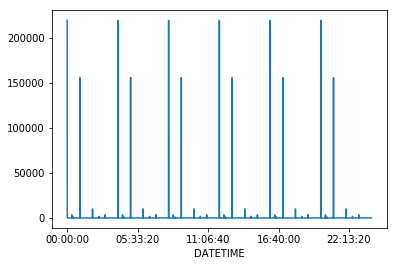

In [144]:
#Check for duplicates
turnstiles_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME']).count().sort_values(by='EXITS_DIFF', ascending = False)
#Need to remove duplicates at the cleaning stage

#Understand the distribution among different times
time_dist = turnstiles_df.groupby([turnstiles_df['DATETIME'].dt.time])['EXITS_DIFF'].count().sort_values(ascending=False)

time_dist.plot()


**Data Cleaning**

In [87]:
#Remove Duplicates

#Remove non-New York stations (start with PTH)
turnstiles_df.groupby(['STATION']).count().sort_values(by='EXITS', ascending=False)

,C/A,UNIT,SCP,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,WEEKDAY,PREV_DATETIME,PREV_EXITS,EXITS_DIFF,TIME_DIFF
STATION,,,,,,,,,,,,,,,,
34 ST-PENN STA,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530,53530
FULTON ST,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604,52604
23 ST,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708,38708
GRD CNTRL-42 ST,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133,35133
CANAL ST,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089,32089
34 ST-HERALD SQ,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583,29583
CHAMBERS ST,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530,29530
59 ST,28885,28885,28885,28885,28885,28885,28885,28885,28885,28885,28885,28885,28884,28884,28884,28884
42 ST-PORT AUTH,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311,28311


In [88]:
#Shorten the data frame
turnstile_short = turnstiles_df[['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME', 'EXITS_DIFF', 'TIME_DIFF']]
turnstile_short.head()

,C/A,UNIT,SCP,STATION,WEEKDAY,DATETIME,EXITS_DIFF,TIME_DIFF
0,A002,R051,02-00-00,59 ST,Saturday,2016-05-28 00:00:00,NaN,NaT
1,A002,R051,02-00-00,59 ST,Saturday,2016-05-28 04:00:00,7.0,04:00:00
2,A002,R051,02-00-00,59 ST,Saturday,2016-05-28 08:00:00,34.0,04:00:00
3,A002,R051,02-00-00,59 ST,Saturday,2016-05-28 12:00:00,93.0,04:00:00
4,A002,R051,02-00-00,59 ST,Saturday,2016-05-28 16:00:00,59.0,04:00:00
